In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")


2024/07/23 01:35:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/23 01:35:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1721698545818, experiment_id='1', last_update_time=1721698545818, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [5]:
df = pd.read_parquet("../data/green_tripdata_2021-01.parquet")

#df = df[df.trip_type == 2]

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [7]:
df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [9]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

In [10]:
x_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [11]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [12]:
target = 'duration'
y_train = df[target].values

In [13]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(x_train)

/tmp/ipykernel_19599/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_19599/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


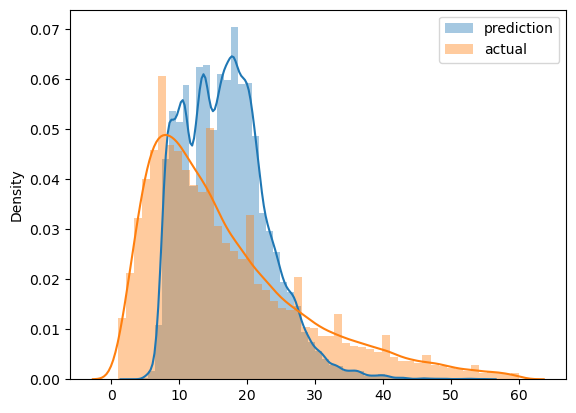

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [16]:
mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829626

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    #df = df[df.trip_type == 2]
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str)

    return df

In [18]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet")

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + "_" + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + "_" + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO']#['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)


val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.7587152107032376

In [24]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Saúl")

    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(x_train, y_train)
    
    y_pred = lr.predict(x_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  0%|                                                                                                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:50:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93911                                                                                                                                    
[1]	validation-rmse:9.92542                                                                                                                                     
[2]	validation-rmse:9.12806                                                                                                                                     
[3]	validation-rmse:8.50513                                                                                                                                     
[4]	validation-rmse:8.02579                                                                                                                                     
[5]	validation-rmse:7.65723                                                                                                                                     
[6]	validation-rmse:7.37817       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:53:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10915                                                                                                                                     
[1]	validation-rmse:7.71665                                                                                                                                     
[2]	validation-rmse:7.13239                                                                                                                                     
[3]	validation-rmse:6.88761                                                                                                                                     
[4]	validation-rmse:6.76984                                                                                                                                     
[5]	validation-rmse:6.71347                                                                                                                                     
[6]	validation-rmse:6.67848       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:55:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.45030                                                                                                                                     
[1]	validation-rmse:6.72352                                                                                                                                     
[2]	validation-rmse:6.58656                                                                                                                                     
[3]	validation-rmse:6.54028                                                                                                                                     
[4]	validation-rmse:6.51033                                                                                                                                     
[5]	validation-rmse:6.49991                                                                                                                                     
[6]	validation-rmse:6.49353       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:56:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59183                                                                                                                                     
[1]	validation-rmse:8.18142                                                                                                                                     
[2]	validation-rmse:7.46389                                                                                                                                     
[3]	validation-rmse:7.10319                                                                                                                                     
[4]	validation-rmse:6.92463                                                                                                                                     
[5]	validation-rmse:6.82520                                                                                                                                     
[6]	validation-rmse:6.76770       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:57:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.64105                                                                                                                                     
[1]	validation-rmse:6.76417                                                                                                                                     
[2]	validation-rmse:6.58142                                                                                                                                     
[3]	validation-rmse:6.52565                                                                                                                                     
[4]	validation-rmse:6.49975                                                                                                                                     
[5]	validation-rmse:6.48304                                                                                                                                     
[6]	validation-rmse:6.47305       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:58:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.47805                                                                                                                                    
[1]	validation-rmse:9.24828                                                                                                                                     
[2]	validation-rmse:8.40100                                                                                                                                     
[3]	validation-rmse:7.82213                                                                                                                                     
[4]	validation-rmse:7.43693                                                                                                                                     
[5]	validation-rmse:7.18015                                                                                                                                     
[6]	validation-rmse:6.99914       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:59:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.04616                                                                                                                                    
[1]	validation-rmse:10.10797                                                                                                                                    
[2]	validation-rmse:9.36158                                                                                                                                     
[3]	validation-rmse:8.77293                                                                                                                                     
[4]	validation-rmse:8.31273                                                                                                                                     
[5]	validation-rmse:7.95594                                                                                                                                     
[6]	validation-rmse:7.67944       

/home/codespace/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:03:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75214                                                                                                                                    
[1]	validation-rmse:11.32484                                                                                                                                    
[2]	validation-rmse:10.92914                                                                                                                                    
[3]	validation-rmse:10.56323                                                                                                                                    
[4]	validation-rmse:10.22480                                                                                                                                    
[5]	validation-rmse:9.91275                                                                                                                                     
[6]	validation-rmse:9.62504       